In [19]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from scipy.linalg import cholesky, solve_triangular
import matplotlib.pyplot as plt


In [21]:
# Battery ECM Model
def ecm_model(state, current, params, dt):
    soc, v1, v2 = state
    r0, r1, r2, c1, c2, capacity = params['r0'], params['r1'], params['r2'], params['c1'], params['c2'], params['capacity']
    # OCV approximation (simple polynomial)
    if soc < 0.1:
        ocv = 3.4 + 0.9 * soc - 0.1 * soc**2 + 0.05 * soc**3
    else:
        ocv = 3.4 + 0.9 * soc - 0.1 * soc**2
    # SOC update
    soc_dot = -current / (capacity * 3600)  # Convert to per-second
    soc_new = soc + soc_dot * dt
    # RC circuit dynamics
    tau1, tau2 = r1 * c1, r2 * c2
    v1_new = v1 * np.exp(-dt / tau1) + r1 * current * (1 - np.exp(-dt / tau1))
    v2_new = v2 * np.exp(-dt / tau2) + r2 * current * (1 - np.exp(-dt / tau2))
    # Terminal voltage
    v_terminal = ocv - current * r0 - v1_new - v2_new
    return np.array([soc_new, v1_new, v2_new]), v_terminal


In [23]:
# SRCKF Functions
def srckf_predict(state, P, current, params, dt, Q):
    n = len(state)
    L = int(np.sqrt(n))
    X = np.zeros((2*n + 1, n))
    X[0] = state
    S = cholesky(P, lower=True)
    for i in range(n):
        X[i + 1] = state + np.sqrt(n) * S[:, i]
        X[i + n + 1] = state - np.sqrt(n) * S[:, i]
    
    X_pred = np.zeros((2*n + 1, n))
    for i in range(2*n + 1):
        X_pred[i], _ = ecm_model(X[i], current, params, dt)
    state_pred = np.mean(X_pred, axis=0)
    diff = X_pred - state_pred
    P_pred = np.dot(diff.T, diff) / (2 * n) + Q
    
    return state_pred, P_pred


In [25]:
def srckf_update(state_pred, P_pred, v_measured, current, params, dt, R):
    n = len(state_pred)
    L = int(np.sqrt(n))
    S = cholesky(P_pred, lower=True)
    X = np.zeros((2*n + 1, n))
    X[0] = state_pred
    for i in range(n):
        X[i + 1] = state_pred + np.sqrt(n) * S[:, i]
        X[i + n + 1] = state_pred - np.sqrt(n) * S[:, i]
    
    Y = np.zeros(2*n + 1)
    for i in range(2*n + 1):
        _, v_terminal = ecm_model(X[i], current, params, dt)
        Y[i] = v_terminal
    
    y_pred = np.mean(Y)
    dy = Y - y_pred
    P_yy = np.dot(dy, dy) / (2 * n) + R
    P_xy = np.zeros((n, 1))
    for i in range(2*n + 1):
        dX = X[i] - state_pred
        P_xy += np.outer(dX, dy[i])
    P_xy /= (2 * n)
    
    K = np.dot(P_xy, np.linalg.inv(P_yy))
    v_residual = v_measured - y_pred
    state_new = state_pred + np.dot(K, v_residual)
    S = cholesky(P_pred, lower=True)
    S = solve_triangular(S, K, lower=True)
    P_new = cholesky(P_pred - np.dot(S, S.T), lower=True)
    
    return state_new.flatten(), P_new


In [27]:
# Data Loading
def load_cycles(csv_folder, metadata_path):
    metadata = pd.read_csv(metadata_path)
    cycles = []
    for index, row in metadata.iterrows():
        cycle_file = row['filename']
        cycle_type = row['type']
        # Use 'cycle_index' if available, otherwise use the row index
        cycle_index = row.get('cycle_index', index)
        capacity = row['capacity'] if 'capacity' in row else 1.9
        df = pd.read_csv(f"{csv_folder}/{cycle_file}")
        cycles.append({'data': df, 'type': cycle_type, 'cycle_index': cycle_index, 'capacity': capacity})
    return cycles


In [29]:
def load_data_for_ml(cycles, max_rows=100000):
    X, y = [], []
    for cycle in cycles:
        df = cycle['data']
        if len(df) > 64:
            for i in range(len(df) - 64):
                seq = df[['Voltage_measured', 'Current_measured', 'Time']].iloc[i:i+64].values
                soc = df['SOC'].iloc[i+64] if 'SOC' in df else 0.5  # Placeholder if SOC not available
                X.append(seq)
                y.append(soc)
        if len(X) >= max_rows:
            break
    if not X:
        return None, None, None, None
    X = np.array(X)
    y = np.array(y)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
    return X_scaled, y, scaler, cycles


In [31]:
# LSTM Model
def train_lstm(X_scaled, y):
    model = Sequential([
        LSTM(50, input_shape=(X_scaled.shape[1], X_scaled.shape[2]), return_sequences=True),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    model.fit(X_scaled, y, epochs=5, batch_size=32, validation_split=0.2, verbose=1)
    return model


Starting process with folder: D:\NASA_Battery_Dataset\cleaned_dataset\data and metadata: D:\NASA_Battery_Dataset\cleaned_dataset\metadata.csv
Starting LSTM training...


C:\Users\AK\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
2517/2517 ━━━━━━━━━━━━━━━━━━━━ 106s 40ms/step - loss: 3.1601e-05 - val_loss: 1.1883e-08
Epoch 2/5
2517/2517 ━━━━━━━━━━━━━━━━━━━━ 89s 35ms/step - loss: 3.6599e-07 - val_loss: 2.3580e-08
Epoch 3/5
2517/2517 ━━━━━━━━━━━━━━━━━━━━ 90s 36ms/step - loss: 8.0852e-08 - val_loss: 9.9196e-10
Epoch 4/5
2517/2517 ━━━━━━━━━━━━━━━━━━━━ 91s 36ms/step - loss: 2.2892e-08 - val_loss: 3.9308e-09
Epoch 5/5
2517/2517 ━━━━━━━━━━━━━━━━━━━━ 95s 38ms/step - loss: 7.4690e-09 - val_loss: 2.3833e-09
First current value (charge): 0.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
Initial SOC from LSTM: 0.50, v1: 0.00, v2: 0.00
Initial v_measured: 3.49, v_terminal_pred: 3.82
⚐ Warning: Initial v_terminal (3.82) differs from v_measured (3.49) by more than 0.1V. Consider adjusting parameters.
Error at index 1 (charge): 0-dimensional array given. Array must be at least two-dimensional


ValueError: x and y must have same first dimension, but have shapes (1620,) and (0,)

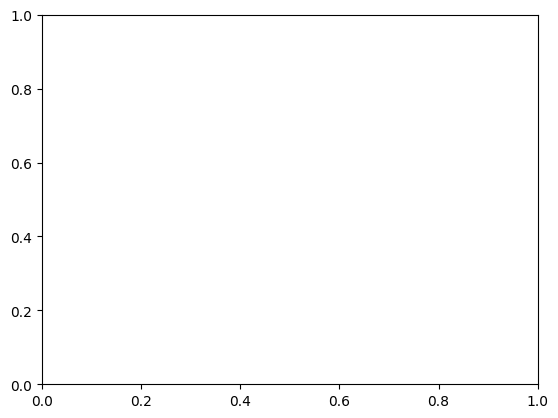

In [33]:
# Main Function
def main():
    csv_folder = r"D:\NASA_Battery_Dataset\cleaned_dataset\data"
    metadata_path = r"D:\NASA_Battery_Dataset\cleaned_dataset\metadata.csv"
    print(f"Starting process with folder: {csv_folder} and metadata: {metadata_path}")
    
    cycles = load_cycles(csv_folder, metadata_path)
    if not cycles:
        print("No cycles loaded. Check file paths, metadata columns, and file contents.")
        return
    
    X_scaled, y_soc, scaler, cycles = load_data_for_ml(cycles, max_rows=100000)
    if X_scaled is None or y_soc is None:
        print("ML data preparation failed. Exiting.")
        return
    
    print("Starting LSTM training...")
    lstm_model = train_lstm(X_scaled, y_soc)
    if lstm_model is None:
        print("LSTM training failed. Exiting.")
        return
    
    params = {'r0': 0.1, 'r1': 0.0688, 'r2': 0.1031, 'c1': 800, 'c2': 3000, 'capacity': 1.9}
    state = np.array([0.1, 0.0, 0.0])  # Initial state: [SOC, v1, v2]
    P = np.eye(3) * 0.1  # Initial covariance
    Q = np.eye(3) * 1e-2  # Process noise
    R = 0.05  # Measurement noise
    
    charge_cycles = [c for c in cycles if c['type'] == 'charge']
    if not charge_cycles:
        print("⚐ No charge cycles found. Exiting.")
        return
    
    charge_cycle = charge_cycles[0]
    df_charge = charge_cycle['data']
    voltages_charge = df_charge['Voltage_measured'].values
    currents_charge = df_charge['Current_measured'].values
    if currents_charge[0] <= 0:
        currents_charge = -currents_charge  # Assume charging current is positive
    print(f"First current value (charge): {currents_charge[0]:.2f}")
    times_charge = df_charge['Time'].values
    params['capacity'] = charge_cycle['capacity'] if charge_cycle['capacity'] > 0 else 1.9
    
    if len(voltages_charge) >= 64:
        features = np.vstack((voltages_charge[:64], currents_charge[:64], times_charge[:64])).T
        features_scaled = scaler.transform(features)
        features_seq = features_scaled[-64:].reshape(1, 64, 3)
        initial_soc = np.clip(lstm_model.predict(features_seq)[0][0], 0, 1)
        state[0] = initial_soc
        
        impedance_cycle = next((c for c in cycles if c['type'] == 'impedance' and c['cycle_index'] == charge_cycle['cycle_index']), None)
        if impedance_cycle:
            params['r1'] = impedance_cycle['r1']
            params['r2'] = impedance_cycle['r2']
            params['c1'] = impedance_cycle['c1']
            params['c2'] = impedance_cycle['c2']
            print(f"Using impedance-derived r1: {params['r1']:.4f}, r2: {params['r2']:.4f}, c1: {params['c1']:.0f}, c2: {params['c2']:.0f}")
        
        dt0 = times_charge[1] - times_charge[0] if len(times_charge) > 1 else 1.0
        i0 = currents_charge[0]
        v0_measured = voltages_charge[0]
        _, v_terminal_initial = ecm_model(state, i0, params, dt0)
        print(f"Initial SOC from LSTM: {initial_soc:.2f}, v1: {state[1]:.2f}, v2: {state[2]:.2f}")
        print(f"Initial v_measured: {v0_measured:.2f}, v_terminal_pred: {v_terminal_initial:.2f}")
        if abs(v0_measured - v_terminal_initial) > 0.1:
            print(f"⚐ Warning: Initial v_terminal ({v_terminal_initial:.2f}) differs from v_measured ({v0_measured:.2f}) by more than 0.1V. Consider adjusting parameters.")
    
    soc_estimates_charge = []
    prev_current = currents_charge[0]
    for t in range(1, len(voltages_charge)):
        try:
            dt = times_charge[t] - times_charge[t-1]
            current = currents_charge[t]
            v_measured = voltages_charge[t]
            if prev_current * current < 0 and abs(current) > 0.01:
                tau1, tau2 = params['r1'] * params['c1'], params['r2'] * params['c2']
                state[1] = current * params['r1'] * (1 - np.exp(-dt / tau1))
                state[2] = current * params['r2'] * (1 - np.exp(-dt / tau2))
            prev_current = current
            state, P = srckf_predict(state, P, current, params, dt, Q)
            state, P = srckf_update(state, P, v_measured, current, params, dt, R)
            soc_estimates_charge.append(state[0])
            _, v_terminal = ecm_model(state, current, params, dt)
            residual = abs(v_measured - v_terminal)
            if residual > 0.1:
                print(f"Warning: High residual {residual:.2f}V at time {times_charge[t]:.2f}s")
            print(f"Time: {times_charge[t]:.2f}s, SOC: {state[0]:.2f}, Current: {current:.2f}, Residual: {residual:.2f}V")
        except Exception as e:
            print(f"Error at index {t} (charge): {e}")
            break

    plt.figure()
    plt.plot(times_charge[1:], soc_estimates_charge, label='Estimated SOC')
    plt.xlabel('Time (s)')
    plt.ylabel('SOC')
    plt.title('SOC Estimation with LSTM-SRCKF')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    from sklearn.preprocessing import StandardScaler
    main()

In [41]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from scipy.linalg import cholesky, solve_triangular
import matplotlib.pyplot as plt

# Battery ECM Model
def ecm_model(state, current, params, dt):
    soc, v1, v2 = state
    r0, r1, r2, c1, c2, capacity = params['r0'], params['r1'], params['r2'], params['c1'], params['c2'], params['capacity']
    # OCV approximation (simple polynomial)
    if soc < 0.1:
        ocv = 3.4 + 0.9 * soc - 0.1 * soc**2 + 0.05 * soc**3
    else:
        ocv = 3.4 + 0.9 * soc - 0.1 * soc**2
    # SOC update
    soc_dot = -current / (capacity * 3600)  # Convert to per-second
    soc_new = soc + soc_dot * dt
    # RC circuit dynamics
    tau1, tau2 = r1 * c1, r2 * c2
    v1_new = v1 * np.exp(-dt / tau1) + r1 * current * (1 - np.exp(-dt / tau1))
    v2_new = v2 * np.exp(-dt / tau2) + r2 * current * (1 - np.exp(-dt / tau2))
    # Terminal voltage
    v_terminal = ocv - current * r0 - v1_new - v2_new
    return np.array([soc_new, v1_new, v2_new]), v_terminal

# SRCKF Functions
def srckf_predict(state, P, current, params, dt, Q):
    n = len(state)
    L = int(np.sqrt(n))
    X = np.zeros((2*n + 1, n))
    X[0] = state
    S = cholesky(P, lower=True)
    for i in range(n):
        X[i + 1] = state + np.sqrt(n) * S[:, i]
        X[i + n + 1] = state - np.sqrt(n) * S[:, i]
    
    X_pred = np.zeros((2*n + 1, n))
    for i in range(2*n + 1):
        X_pred[i], _ = ecm_model(X[i], current, params, dt)
    state_pred = np.mean(X_pred, axis=0)
    diff = X_pred - state_pred
    P_pred = np.dot(diff.T, diff) / (2 * n) + Q
    
    return state_pred, P_pred

def srckf_update(state_pred, P_pred, v_measured, current, params, dt, R):
    n = len(state_pred)
    L = int(np.sqrt(n))
    S = cholesky(P_pred, lower=True)
    X = np.zeros((2*n + 1, n))
    X[0] = state_pred
    for i in range(n):
        X[i + 1] = state_pred + np.sqrt(n) * S[:, i]
        X[i + n + 1] = state_pred - np.sqrt(n) * S[:, i]
    
    Y = np.zeros(2*n + 1)
    for i in range(2*n + 1):
        _, v_terminal = ecm_model(X[i], current, params, dt)
        Y[i] = v_terminal
    
    y_pred = np.mean(Y)
    dy = Y - y_pred
    P_yy = np.dot(dy, dy) / (2 * n) + R
    if P_yy.shape == ():
        P_yy = P_yy.reshape(1, 1)
    if np.abs(np.linalg.det(P_yy)) < 1e-10:  # Check for near-singularity
        P_yy += 1e-6 * np.eye(1)
        print("Regularized P_yy due to near-singularity")
    P_xy = np.zeros((n, 1))
    for i in range(2*n + 1):
        dX = X[i] - state_pred
        P_xy += np.outer(dX.reshape(-1, 1), dy[i:i+1].T)
    P_xy /= (2 * n)
    
    K = np.dot(P_xy, np.linalg.inv(P_yy))
    v_residual = np.array([[v_measured - y_pred]])
    state_new = state_pred + np.dot(K, v_residual).flatten()
    S = cholesky(P_pred, lower=True)
    K_2d = K.reshape(-1, 1) if K.ndim == 1 else K  # Ensure K is 2D
    S = solve_triangular(S, K_2d, lower=True)
    P_new = P_pred - np.dot(S, S.T)
    P_new += 1e-6 * np.eye(n)  # Regularize to ensure positive definiteness
    P_new = cholesky(P_new, lower=True)
    
    return state_new, P_new

# Data Loading
def load_cycles(csv_folder, metadata_path):
    metadata = pd.read_csv(metadata_path)
    cycles = []
    for index, row in metadata.iterrows():
        cycle_file = row['filename']
        cycle_type = row['type']
        cycle_index = row.get('cycle_index', index)
        capacity = row['capacity'] if 'capacity' in row else 1.9
        df = pd.read_csv(f"{csv_folder}/{cycle_file}")
        cycles.append({'data': df, 'type': cycle_type, 'cycle_index': cycle_index, 'capacity': capacity})
    return cycles

def load_data_for_ml(cycles, max_rows=100000):
    X, y = [], []
    for cycle in cycles:
        df = cycle['data']
        if len(df) > 64:
            for i in range(len(df) - 64):
                seq = df[['Voltage_measured', 'Current_measured', 'Time']].iloc[i:i+64].values
                soc = df['SOC'].iloc[i+64] if 'SOC' in df else 0.5  # Placeholder if SOC not available
                X.append(seq)
                y.append(soc)
        if len(X) >= max_rows:
            break
    if not X:
        return None, None, None, None
    X = np.array(X)
    y = np.array(y)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
    return X_scaled, y, scaler, cycles

# LSTM Model
def train_lstm(X_scaled, y):
    model = Sequential([
        LSTM(50, input_shape=(X_scaled.shape[1], X_scaled.shape[2]), return_sequences=True),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    model.fit(X_scaled, y, epochs=5, batch_size=32, validation_split=0.2, verbose=1)
    return model

# Main Function
def main():
    csv_folder = r"D:\NASA_Battery_Dataset\cleaned_dataset\data"
    metadata_path = r"D:\NASA_Battery_Dataset\cleaned_dataset\metadata.csv"
    print(f"Starting process with folder: {csv_folder} and metadata: {metadata_path}")
    
    cycles = load_cycles(csv_folder, metadata_path)
    if not cycles:
        print("No cycles loaded. Check file paths, metadata columns, and file contents.")
        return
    
    X_scaled, y_soc, scaler, cycles = load_data_for_ml(cycles, max_rows=100000)
    if X_scaled is None or y_soc is None:
        print("ML data preparation failed. Exiting.")
        return
    
    print("Starting LSTM training...")
    lstm_model = train_lstm(X_scaled, y_soc)
    if lstm_model is None:
        print("LSTM training failed. Exiting.")
        return
    
    params = {'r0': 0.15, 'r1': 0.0688, 'r2': 0.1031, 'c1': 800, 'c2': 3000, 'capacity': 1.9}
    state = np.array([0.1, 0.0, 0.0])  # Initial state: [SOC, v1, v2]
    P = np.eye(3) * 0.1  # Initial covariance
    Q = np.eye(3) * 1e-2  # Process noise
    R = 0.1  # Increased measurement noise for stability
    
    charge_cycles = [c for c in cycles if c['type'] == 'charge']
    if not charge_cycles:
        print("⚐ No charge cycles found. Exiting.")
        return
    
    charge_cycle = charge_cycles[0]
    df_charge = charge_cycle['data']
    voltages_charge = df_charge['Voltage_measured'].values
    currents_charge = df_charge['Current_measured'].values
    if currents_charge[0] <= 0:
        currents_charge = -currents_charge  # Assume charging current is positive
    print(f"First current value (charge): {currents_charge[0]:.2f}")
    times_charge = df_charge['Time'].values
    params['capacity'] = charge_cycle['capacity'] if charge_cycle['capacity'] > 0 else 1.9
    
    if len(voltages_charge) >= 64:
        features = np.vstack((voltages_charge[:64], currents_charge[:64], times_charge[:64])).T
        features_scaled = scaler.transform(features)
        features_seq = features_scaled[-64:].reshape(1, 64, 3)
        initial_soc = np.clip(lstm_model.predict(features_seq)[0][0], 0, 1)
        state[0] = initial_soc
        
        impedance_cycle = next((c for c in cycles if c['type'] == 'impedance' and c['cycle_index'] == charge_cycle['cycle_index']), None)
        if impedance_cycle:
            params['r1'] = impedance_cycle['r1']
            params['r2'] = impedance_cycle['r2']
            params['c1'] = impedance_cycle['c1']
            params['c2'] = impedance_cycle['c2']
            print(f"Using impedance-derived r1: {params['r1']:.4f}, r2: {params['r2']:.4f}, c1: {params['c1']:.0f}, c2: {params['c2']:.0f}")
        
        dt0 = times_charge[1] - times_charge[0] if len(times_charge) > 1 else 1.0
        i0 = currents_charge[0]
        v0_measured = voltages_charge[0]
        _, v_terminal_initial = ecm_model(state, i0, params, dt0)
        print(f"Initial SOC from LSTM: {initial_soc:.2f}, v1: {state[1]:.2f}, v2: {state[2]:.2f}")
        print(f"Initial v_measured: {v0_measured:.2f}, v_terminal_pred: {v_terminal_initial:.2f}")
        if abs(v0_measured - v_terminal_initial) > 0.1:
            print(f"⚐ Warning: Initial v_terminal ({v_terminal_initial:.2f}) differs from v_measured ({v0_measured:.2f}) by more than 0.1V. Consider adjusting parameters.")
    
    soc_estimates_charge = []
    prev_current = currents_charge[0]
    for t in range(1, len(voltages_charge)):
        try:
            dt = times_charge[t] - times_charge[t-1]
            current = currents_charge[t]
            v_measured = voltages_charge[t]
            if prev_current * current < 0 and abs(current) > 0.01:
                tau1, tau2 = params['r1'] * params['c1'], params['r2'] * params['c2']
                state[1] = current * params['r1'] * (1 - np.exp(-dt / tau1))
                state[2] = current * params['r2'] * (1 - np.exp(-dt / tau2))
            prev_current = current
            state, P = srckf_predict(state, P, current, params, dt, Q)
            state, P = srckf_update(state, P, v_measured, current, params, dt, R)
            soc_estimates_charge.append(state[0])
            _, v_terminal = ecm_model(state, current, params, dt)
            residual = abs(v_measured - v_terminal)
            if residual > 0.1:
                print(f"Warning: High residual {residual:.2f}V at time {times_charge[t]:.2f}s")
            print(f"Time: {times_charge[t]:.2f}s, SOC: {state[0]:.2f}, Current: {current:.2f}, Residual: {residual:.2f}V")
        except Exception as e:
            print(f"Error at index {t} (charge): {e}")
            break

    if soc_estimates_charge:
        plt.figure()
        plt.plot(times_charge[1:], soc_estimates_charge, label='Estimated SOC')
        plt.xlabel('Time (s)')
        plt.ylabel('SOC')
        plt.title('SOC Estimation with LSTM-SRCKF')
        plt.legend()
        plt.show()
    else:
        print("No SOC estimates generated. Check SRCKF implementation.")

if __name__ == "__main__":
    from sklearn.preprocessing import StandardScaler
    main()

Starting process with folder: D:\NASA_Battery_Dataset\cleaned_dataset\data and metadata: D:\NASA_Battery_Dataset\cleaned_dataset\metadata.csv
Starting LSTM training...
Epoch 1/5


C:\Users\AK\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2517/2517 ━━━━━━━━━━━━━━━━━━━━ 90s 34ms/step - loss: 3.6569e-05 - val_loss: 1.7888e-07
Epoch 2/5
2517/2517 ━━━━━━━━━━━━━━━━━━━━ 87s 35ms/step - loss: 4.8661e-07 - val_loss: 7.9096e-09
Epoch 3/5
2517/2517 ━━━━━━━━━━━━━━━━━━━━ 87s 35ms/step - loss: 1.0474e-07 - val_loss: 9.7168e-09
Epoch 4/5
2517/2517 ━━━━━━━━━━━━━━━━━━━━ 88s 35ms/step - loss: 2.3946e-08 - val_loss: 7.2636e-09
Epoch 5/5
2517/2517 ━━━━━━━━━━━━━━━━━━━━ 90s 36ms/step - loss: 5.4288e-09 - val_loss: 6.4782e-10
First current value (charge): 0.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
Initial SOC from LSTM: 0.50, v1: 0.00, v2: 0.00
Initial v_measured: 3.49, v_terminal_pred: 3.82
⚐ Warning: Initial v_terminal (3.82) differs from v_measured (3.49) by more than 0.1V. Consider adjusting parameters.
Error at index 1 (charge): 1-th leading minor of the array is not positive definite
No SOC estimates generated. Check SRCKF implementation.
